In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from urllib.request import urlopen

from torch.distributions.constraints import positive

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.contrib.oed.eig import marginal_eig, nmc_eig
from pyro.nn.module import to_pyro_module_
import pyro.poutine as poutine
from pyro.contrib.util import lexpand

from pyro_oed_src import posterior_eig, vnmc_eig, _safe_mean_terms

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math

In [2]:
N = 2000 # total number of points
p = 8 # num of samples per each axis of (t_1, t_2)

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
times = np.linspace(0,2*np.pi,N)

designs = torch.tensor(times[indices])
#designs = torch.tensor(indices)
print(designs.shape[-2:])

torch.Size([64, 2])


In [3]:
w_1 = torch.tensor(1.0)
w_2 = torch.tensor(3.0)
sigma = torch.tensor(0.1)

def model(t):
    w = pyro.sample("w", dist.Uniform(w_1,w_2))
    phase = pyro.sample("phase", dist.Uniform(np.pi/2, 3*np.pi/2))
    with pyro.plate_stack("plate", t.shape[:-1]): # create a continguous stack of plates, Pyro adds dimensions to the left
        y_true = torch.sin(w*t+phase)
        return pyro.sample("y", dist.Normal(y_true,sigma).to_event(1)) # to_event: num of batch dimensions (from right) to reinterpret as event dimensions

In [4]:
test_w = 2.75
test_phase = np.pi
con_model = pyro.condition(model, {"w": test_w, "phase": test_phase}) # fix parameters
y_output = con_model(designs)

Text(0, 0.5, 'Amplitude')

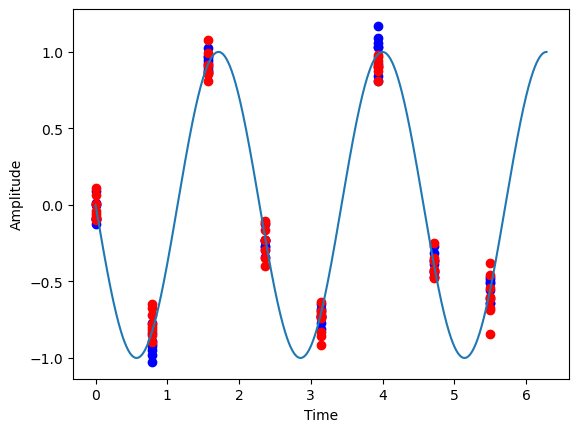

In [5]:
plt.scatter(designs[:,0], y_output[:,0], c="blue")
plt.scatter(designs[:,1],y_output[:,1], c="red")
plt.plot(times,np.sin(test_w*times+test_phase))
plt.xlabel("Time")
plt.ylabel("Amplitude")

In [6]:
target_labels = ["w", "phase"]
traced_structure = pyro.poutine.trace(con_model).get_trace(designs)

In [112]:
trace = poutine.trace(model).get_trace(expanded_design)

In [109]:
y_dict = trace.nodes["y"]

In [8]:
def posterior_guide(y_dict, design, observation_labels, target_labels):
    alpha = pyro.param("alpha", torch.ones(design.shape))
    beta = pyro.param("beta", torch.ones(design.shape))
    freq_mean = alpha*y_dict["y"]
    phase_mean = beta*y_dict["y"]
    #freq_mean = pyro.param("freq_mean", torch.ones(design.shape[1]))
    freq_sd = pyro.param("freq_sd", torch.ones(design.shape), constraint=positive)
    #phase_mean = pyro.param("phase_mean", torch.ones(design.shape[1]))
    phase_sd = pyro.param("phase_sd", torch.ones(design.shape), constraint=positive)
    pyro.sample("w", dist.Normal(freq_mean, freq_sd).to_event(1))
    pyro.sample("phase", dist.Normal(phase_mean, phase_sd).to_event(1))

In [4]:
class posterior_guide_nn(nn.Module):
    def __init__(self, in_features, lay1_out, lay2_out):
        super().__init__()
        self.fa1 = nn.Linear(in_features, lay1_out)
        self.fa2 = nn.Linear(lay1_out, lay2_out)
        self.fa3 = nn.Linear(lay2_out,1)

        self.pa1 = nn.Linear(in_features, lay1_out)
        self.pa2 = nn.Linear(lay1_out, lay2_out)
        self.pa3 = nn.Linear(lay2_out,1)

        self.fb1 = nn.Linear(in_features, lay1_out)
        self.fb2 = nn.Linear(lay1_out, lay2_out)
        self.fb3 = nn.Linear(lay2_out,1)
        
        self.pb1 = nn.Linear(in_features, lay1_out)
        self.pb2 = nn.Linear(lay1_out, lay2_out)
        self.pb3 = nn.Linear(lay2_out,1)


    def freq_nn_a(self, input):
        z = nn.functional.relu(self.fa1(input))
        z = nn.functional.relu(self.fa2(z))
        return self.fa3(z)
    
    def phase_nn_a(self, input):
        z = nn.functional.relu(self.pa1(input))
        z = nn.functional.relu(self.pa2(z))
        return self.pa3(z)
    
    def freq_nn_b(self, input):
        z = nn.functional.relu(self.fb1(input))
        z = nn.functional.relu(self.fb2(z))
        return self.fb3(z)
    
    def phase_nn_b(self, input):
        z = nn.functional.relu(self.pb1(input))
        z = nn.functional.relu(self.pb2(z))
        return self.pb3(z)
    
    def forward(self, y_dict, design, observation_labels, target_labels):

        pyro.module("posterior_guide", self) # registers all parameters of a torch.nn.Module with Pyro's param_store

        y = y_dict["y"].float()
        #z = torch.cat((y,design), dim=-1).float() # concatenate times of design into nn input
        
        freq_alpha = self.freq_nn_a(y).exp()
        phase_alpha = self.phase_nn_a(y).exp()

        freq_beta = self.freq_nn_b(y).exp()
        phase_beta = self.phase_nn_b(y).exp()

        pyro.sample("w", dist.AffineBeta(freq_alpha, freq_beta, 1, 2)) # scaled beta distribution inputs:(alpha, beta, loc, scale) f(X) = loc + scale*X
        pyro.sample("phase", dist.AffineBeta(phase_alpha, phase_beta, np.pi/2, np.pi))

In [5]:
eigs = {}
full_history = []

pyro.set_rng_seed(3)
num_steps, start_lr, end_lr = 200, 0.1, 0.001

# optimizer = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam,
#                                      'optim_args': {'lr': start_lr},
#                                      'gamma': (end_lr / start_lr) ** (1 / num_steps)}) # decays the lr of each param group by gamma 

nn_guide = posterior_guide_nn(designs.shape[-1], 16, 32)
for times in designs:
    pyro.clear_param_store()
    eig, history = posterior_eig(model,
                    times,                          # tensor of possible designs
                    "y",                            # observation labels
                    ["w", "phase"],                 # target (parameter) labels
                    num_samples=5000,                # number of samples to draw per step in the expectation
                    num_steps=num_steps,            # number of gradient steps
                    guide=nn_guide,                 # guide q(y)
                    optim=Adam({'lr': 0.01}),      # optimizer 
                    eig=True,                       # compute the average posterior entropy (APE) instead of the EIG (if false)
                    return_history=True             # returns a tensor giving the loss function at each step of optimization
                    ) 
    full_history.append(history)
    eigs[times] = eig


full_history = torch.stack(full_history)

# The APE is related to the EIG by: EIG(d) = H(p(theta))-APE(d) 
# where H is the differential entropy.

In [6]:
history_array = full_history.detach().numpy()

average_loss_no_design = history_array.sum(axis=0)/history_array.shape[0]

(0.0, 7.0)

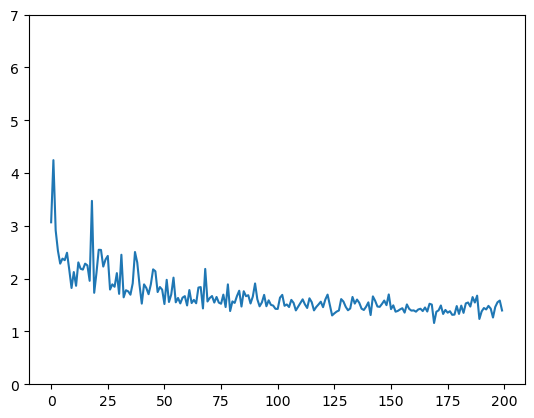

In [7]:
plt.figure()
plt.plot(range(num_steps), average_loss_no_design)
plt.ylim(0,7)

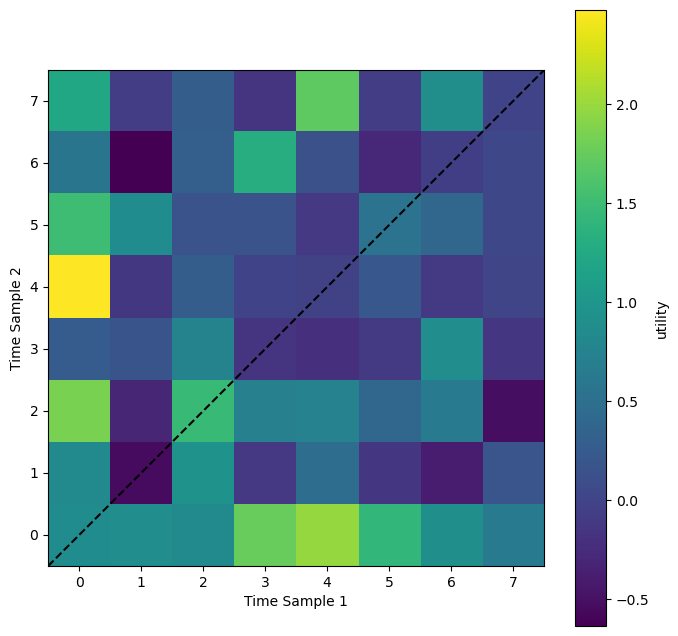

In [8]:
eigs_list = np.array([i.detach().numpy()[0] for i in eigs.values()])
plt.figure(figsize=(8,8))
img_2D = plt.imshow(eigs_list.reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.axline((0,0), slope=1, c='black', linestyle='--')
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()

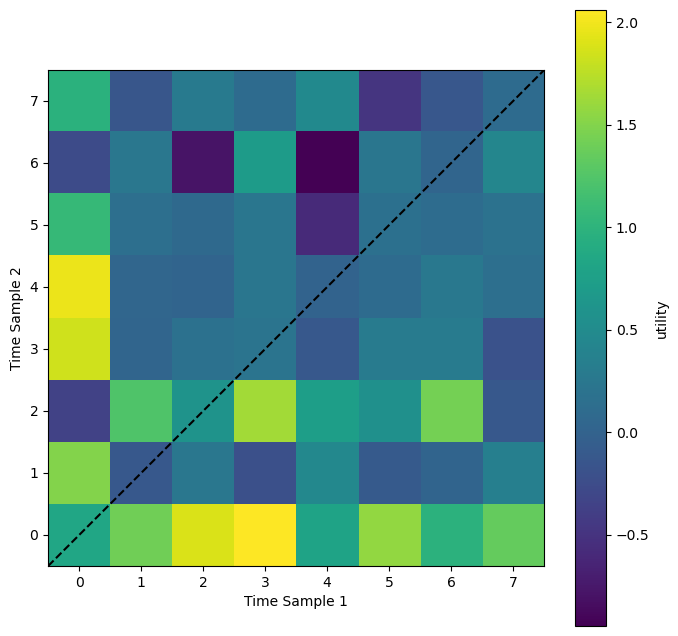

In [8]:
# with amortized designs
eigs_list = np.array([i.detach().numpy()[0] for i in eigs.values()])
plt.figure(figsize=(8,8))
img_2D = plt.imshow(eigs_list.reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.axline((0,0), slope=1, c='black', linestyle='--')
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()

In [26]:
eigs_vnmc_lower = {}
eigs_vnmc_upper = {}
full_history_vnmc = []
pyro.set_rng_seed(4)
num_steps = 100
N = 200
M = np.sqrt(N).astype(int)

nn_guide = posterior_guide_nn(2*designs.shape[-1], 32, 64)
for times in designs:
    pyro.clear_param_store()
    eig = vnmc_eig(model,
                    times,                          # tensor of possible designs
                    "y",                            # observation labels
                    ["w", "phase"],                 # target (parameter) labels
                    num_samples=(N,M),              # tuple of outer and inner (respectively) num of samples
                    num_steps=num_steps,            # number of gradient steps
                    guide=nn_guide,                 # guide q(y)
                    optim=Adam({'lr': 0.01}),       # optimizer 
                    return_history=False,             # returns a tensor giving the loss function at each step of optimization
                    contrastive=True
                    ) 
    #full_history_vnmc.append((history_lower, history_upper))
    eigs_vnmc_lower[times] = eig[0]
    eigs_vnmc_upper[times] = eig[1]


In [15]:
lower = np.array([i.detach().numpy() for i in eigs_vnmc_lower.values()])
upper = np.array([i.detach().numpy() for i in eigs_vnmc_upper.values()])

In [27]:
lower = np.array([i.detach().numpy() for i in eigs_vnmc_lower.values()])
upper = np.array([i.detach().numpy() for i in eigs_vnmc_upper.values()])
print(upper-lower)
print(np.mean(upper-lower))

[ 0.00706065  0.05486107  0.03068972 -0.014081    0.03411341  0.2438922
  0.01203251  0.06008625  0.06164622  0.00345743  0.27070665  0.28760624
  0.04329133  0.24961472  0.16385889  0.08570337  0.02594233  1.238781
  0.0344367   0.30228376  0.03138018  0.67232704  0.27425575  0.11543322
  0.22403622  0.07351017  0.02846289  0.01822114  0.1130302   0.08160377
  0.33804464  0.35730267  0.20294714  0.1005373   0.08531713  0.42807245
  0.02754951  0.2012968   0.31279564  0.34555435  0.25278664  0.16850019
  0.06502676  0.02538967  0.5024133   0.04921865  0.20185661  0.21475744
  0.01288772  0.0494256   0.52883244  0.5228367   0.7772231   0.13012028
  0.05794549  0.4210534   0.13601542  0.02479029  0.22734404  0.06749964
  0.26599073  0.2895627   0.15649986  0.04798698]
0.19411916


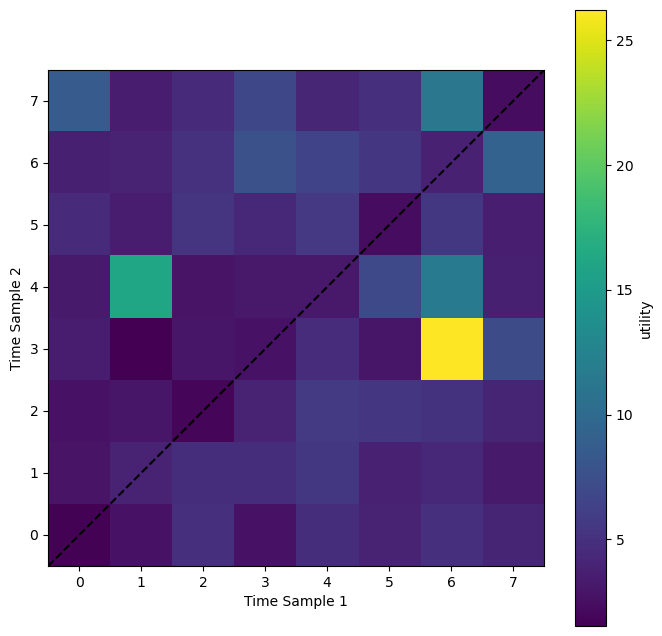

In [ ]:
eigs_vnmc_list = np.array([i.detach().numpy() for i in eigs_vnmc.values()])
plt.figure(figsize=(8,8))
img_2D = plt.imshow(eigs_vnmc_list.reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.axline((0,0), slope=1, c='black', linestyle='--')
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()

In [11]:
N = 200
M = np.sqrt(N).astype(int)

nn_guide = posterior_guide_nn(2*designs.shape[-1], 32, 64)

expanded_design = lexpand(designs, N)
#print(expanded_design.shape)
trace = poutine.trace(model).get_trace(expanded_design)
y_dict = {l: lexpand(trace.nodes[l]["value"], M) for l in ["y"]}
print(y_dict["y"].shape)

reexpanded_design = lexpand(expanded_design, M)
#print(reexpanded_design.shape)
conditional_guide = pyro.condition(nn_guide, data=y_dict)
guide_trace = poutine.trace(conditional_guide).get_trace(y_dict, reexpanded_design, ["y"], ["w", "phase"])

theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in ["w", "phase"]}
theta_y_dict.update(y_dict)
guide_trace.compute_log_prob()

modelp = pyro.condition(model, data=theta_y_dict)
model_trace = poutine.trace(modelp).get_trace(reexpanded_design)
model_trace.compute_log_prob()

terms = -sum(guide_trace.nodes[l]["log_prob"] for l in ["w", "phase"])
terms += sum(model_trace.nodes[l]["log_prob"] for l in ["w", "phase"])
terms = terms.squeeze()
terms += sum(model_trace.nodes[l]["log_prob"] for l in ["y"])
#print(terms.shape)
#print(theta_y_dict.keys())
#terms.squeeze()
#print(terms.shape)
#print(terms[1:].shape)
#print(terms[1:].logsumexp(0))
#print(terms.logsumexp?)
#print(sum(model_trace.nodes[l]["log_prob"] for l in ["y"]).shape)
#terms = -terms.logsumexp(0) + math.log(M)

torch.Size([14, 200, 64, 2])


In [12]:
def loss_fn(design, num_particles, evaluation=False, **kwargs):
    N, M = num_particles
    expanded_design = lexpand(design, N)

    # Sample from p(y, theta | d)
    trace = poutine.trace(model).get_trace(expanded_design)
    y_dict = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}

    # Sample M times from q(theta | y, d) for each y
    reexpanded_design = lexpand(expanded_design, M)
    conditional_guide = pyro.condition(guide, data=y_dict)
    guide_trace = poutine.trace(conditional_guide).get_trace(
        y_dict, reexpanded_design, observation_labels, target_labels
    )
    theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in target_labels}
    theta_y_dict.update(y_dict)
    guide_trace.compute_log_prob()

    # Re-run that through the model to compute the joint
    modelp = pyro.condition(model, data=theta_y_dict)
    model_trace = poutine.trace(modelp).get_trace(reexpanded_design)
    model_trace.compute_log_prob()

    terms = -sum(guide_trace.nodes[l]["log_prob"] for l in target_labels)
    terms += sum(model_trace.nodes[l]["log_prob"] for l in target_labels)
    terms = terms.squeeze()
    terms += sum(model_trace.nodes[l]["log_prob"] for l in observation_labels)
    if contrastive:
        lower_terms = -terms.logsumexp(0) + math.log(M) # returns log summed exponentials of each row of the input tensor in the given dim (0)
        upper_terms = -terms[1:].logsumexp(0) + math.log(M-1)
        if evaluation:
            trace.compute_log_prob()
            lower_terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
            upper_terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
        lower_agg_loss, lower_loss = _safe_mean_terms(lower_terms)
        upper_agg_loss, upper_loss = _safe_mean_terms(upper_terms)
        agg_loss = (lower_agg_loss, upper_agg_loss)
        loss = (lower_loss, upper_loss)
        return agg_loss, loss
    else:
        terms = -terms.logsumexp(0) + math.log(M)
        if evaluation:
            # At eval time, add p(y | theta, d) terms
            trace.compute_log_prob()
            terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
        return _safe_mean_terms(terms)

In [19]:
design = designs[0]
num_samples = (N,M)
return_history = True
observation_labels = ["y"]
target_labels = ["w", "phase"]
guide = posterior_guide_nn(2*designs.shape[-1], 32, 64)
contrastive = False

params = None
history = []
for step in range(num_steps):
    if params is not None:
        pyro.infer.util.zero_grads(params)
    with poutine.trace(param_only=True) as param_capture:
        agg_loss, loss = loss_fn(design, num_samples, evaluation=return_history)
    params = set(
        site["value"].unconstrained() for site in param_capture.trace.nodes.values()
    )
    if torch.isnan(agg_loss):
        raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
    agg_loss.backward(retain_graph=True)
    print(agg_loss)
    if return_history:
        history.append(loss)
    optim(params)
    try:
        optim.step()
    except AttributeError:
        pass 

tensor(3.4014, grad_fn=<SumBackward0>)


NameError: name 'optim' is not defined

In [16]:
design = designs[0]
num_samples = (N,M)
return_history = True
observation_labels = ["y"]
target_labels = ["w", "phase"]
guide = posterior_guide_nn(2*designs.shape[-1], 32, 64)
contrastive = True

params = None
history_upper = []
history_lower = []
for step in range(num_steps):
    if params is not None:
        pyro.infer.util.zero_grads(params)
    with poutine.trace(param_only=True) as param_capture:
        agg_loss, loss = loss_fn(design, num_samples, evaluation=return_history)
    params = set(site["value"].unconstrained()
                for site in param_capture.trace.nodes.values())
    if torch.isnan(agg_loss[0]) or torch.isnan(agg_loss[1]):
        raise ArithmeticError("Encountered NaN loss in opt_eig_ape_loss")
    print(agg_loss[0])
    agg_loss[0].backward(retain_graph=True)
    agg_loss[1].backward(retrain_graph=True)
    if return_history:
        history_lower.append(loss[0])
        history_upper.append(loss[1])
    optim(params)
    try:
        optim.step()
    except AttributeError:
        pass


tensor(2.6627, grad_fn=<SumBackward0>)


TypeError: backward() got an unexpected keyword argument 'retrain_graph'

In [214]:
sum(model_trace.nodes["w"]["log_prob"],model_trace.nodes["phase"]["log_prob"]).shape

torch.Size([44, 2000, 1])

In [210]:
model_trace.nodes["y"]["log_prob"]

torch.Size([44, 2000])

In [206]:
model_trace.nodes["y"]["log_prob"].shape

torch.Size([44, 2000])

In [200]:
guide_trace.nodes['posterior_guide$$$fa1.bias']

{'type': 'param',
 'name': 'posterior_guide$$$fa1.bias',
 'fn': <bound method ParamStoreDict.get_param of <pyro.params.param_store.ParamStoreDict object at 0x7f85aa210610>>,
 'is_observed': False,
 'args': ('posterior_guide$$$fa1.bias',
  Parameter containing:
  tensor([-0.0664,  0.2609, -0.0803,  0.4391, -0.0038, -0.1055,  0.1734, -0.0253,
           0.4003, -0.0702,  0.3361, -0.1293,  0.0439,  0.1622, -0.4693,  0.0962,
           0.2719,  0.1974,  0.0123, -0.0516,  0.1574,  0.1514, -0.2409,  0.1952,
          -0.4282,  0.0197, -0.1719, -0.2092, -0.4055,  0.3930,  0.0461,  0.0344],
         requires_grad=True)),
 'kwargs': {'constraint': Real(), 'event_dim': None},
 'value': Parameter containing:
 tensor([-0.0664,  0.2609, -0.0803,  0.4391, -0.0038, -0.1055,  0.1734, -0.0253,
          0.4003, -0.0702,  0.3361, -0.1293,  0.0439,  0.1622, -0.4693,  0.0962,
          0.2719,  0.1974,  0.0123, -0.0516,  0.1574,  0.1514, -0.2409,  0.1952,
         -0.4282,  0.0197, -0.1719, -0.2092, -0.40

In [79]:
param_dict = pyro.get_param_store()
param_dict.keys()


dict_keys([])

In [230]:
param_dict['beta'].shape

torch.Size([300, 100, 2])

In [304]:
def marginal_guide(design, observation_labels, target_labels):
    marg_mean = pyro.param("marg_mean", torch.ones(design.shape))
    marg_sd = pyro.param("marg_sd", torch.ones(design.shape), constraint=positive)
    pyro.sample("y", dist.Normal(marg_mean, marg_sd).to_event(1))

In [305]:
pyro.clear_param_store()
num_steps, start_lr, end_lr = 1000, 0.1, 0.001
optimizer = pyro.optim.ExponentialLR({'optimizer': torch.optim.Adam,
                                      'optim_args': {'lr': start_lr},
                                      'gamma': (end_lr / start_lr) ** (1 / num_steps)})

marginal_eig_output = marginal_eig(model,
                   designs,                 # tensor of possible designs
                   "y",                     # observation labels
                   ["w", "phase"],          # target (parameter) labels
                   num_samples=2000,         # number of samples to draw per step in the expectation
                   num_steps=num_steps,     # number of gradient steps
                   guide=marginal_guide,   # guide q(y)
                   optim=optimizer,         # optimizer with learning rate decay
                   ) 

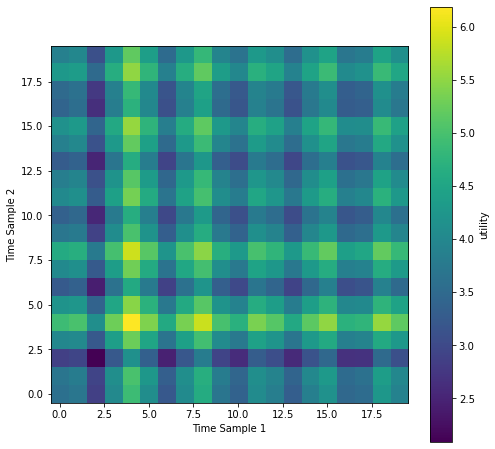

In [306]:
plt.figure(figsize=(8,8))
img_2D = plt.imshow(marginal_eig_output.detach().numpy().reshape(p,p), origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()